In [1]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import glob
%pylab inline
%config InlineBackend.figure_format='retina'


# YOU SUBTRACT BIASES

Populating the interactive namespace from numpy and matplotlib


In [29]:
files = glob.glob('/Users/jessmcd/Documents/other/20170430_RapidProbeData/20170501_masstest/*.csv')

#df_t = pd.DataFrame()

for f in files:
    df = pd.read_csv(f, index_col=0)
    ID = '0'+str(int(df['ID'][0]))+'A'
    print(ID)
    
    if f == files[0]:
        df_t = pd.DataFrame(data=df['T'].values, index = df.index, columns=[ID])
        df_rh = pd.DataFrame(data=df['RH'].values, index = df.index, columns=[ID])
        df_p = pd.DataFrame(data=df['P'].values, index = df.index, columns=[ID])
    else:
      
        temp = pd.DataFrame(data=df['T'].values, index = df.index, columns=[ID])
        df_t = df_t.merge(temp,left_index=True,right_index=True, right_on=temp.index)
        
        temp = pd.DataFrame(data=df['RH'].values, index = df.index, columns=[ID])
        df_rh = df_rh.merge(temp,left_index=True,right_index=True, right_on=temp.index)
        
        temp = pd.DataFrame(data=df['P'].values, index = df.index, columns=[ID])
        df_p = df_p.merge(temp,left_index=True,right_index=True, right_on=temp.index)
        
        df_t.drop(columns=['key_0'], inplace=True)
        df_rh.drop(columns=['key_0'], inplace=True)
        df_p.drop(columns=['key_0'], inplace=True)

        
        
# convert to proper datetime objects        
df_t.index = pd.to_datetime(df_t.index)
df_rh.index = pd.to_datetime(df_rh.index)
df_p.index = pd.to_datetime(df_p.index)

# get 1 min averaged data for plotting
df_t_M = np.round(df_t.resample('1Min', label='right').mean(),1)
df_rh_M = np.round(df_rh.resample('1Min', label='right').mean(),1)
df_p_M = np.round(df_p.resample('1Min', label='right').mean(),1)

# find global mean
overall_mean_t = df_t.mean(skipna=True).mean()
overall_mean_rh = df_rh.mean(skipna=True).mean()
overall_mean_p = df_p.mean(skipna=True).mean()

# get sticknets to loop over
SN = sorted(df_t.columns)


# calculate biases
biases = pd.DataFrame(index=list(SN), columns=['T', 'RH', 'P'])

for sn in SN:

    biases.loc[sn, 'T']  = np.round(df_t[sn].mean(skipna=True)-overall_mean_t, 1)
    biases.loc[sn, 'RH'] = np.round(df_rh[sn].mean(skipna=True)-overall_mean_rh,1)
    biases.loc[sn, 'P']  = np.round(df_p[sn].mean(skipna=True)-overall_mean_p,1)

biases

0224A
0219A
0220A
0221A
0218A
0222A


,T,RH,P
0218A,-0.4,-0.2,-0.2
0219A,0.1,-0.3,-0.1
0220A,-0,-0.7,-0.3
0221A,0.4,-0.7,1.5
0222A,0.1,1.7,-0.1
0224A,-0.2,0.1,-0.8


In [34]:
biases.to_csv('/Users/jessmcd/Documents/other/20170430_RapidProbeData/20170430_bias.txt')

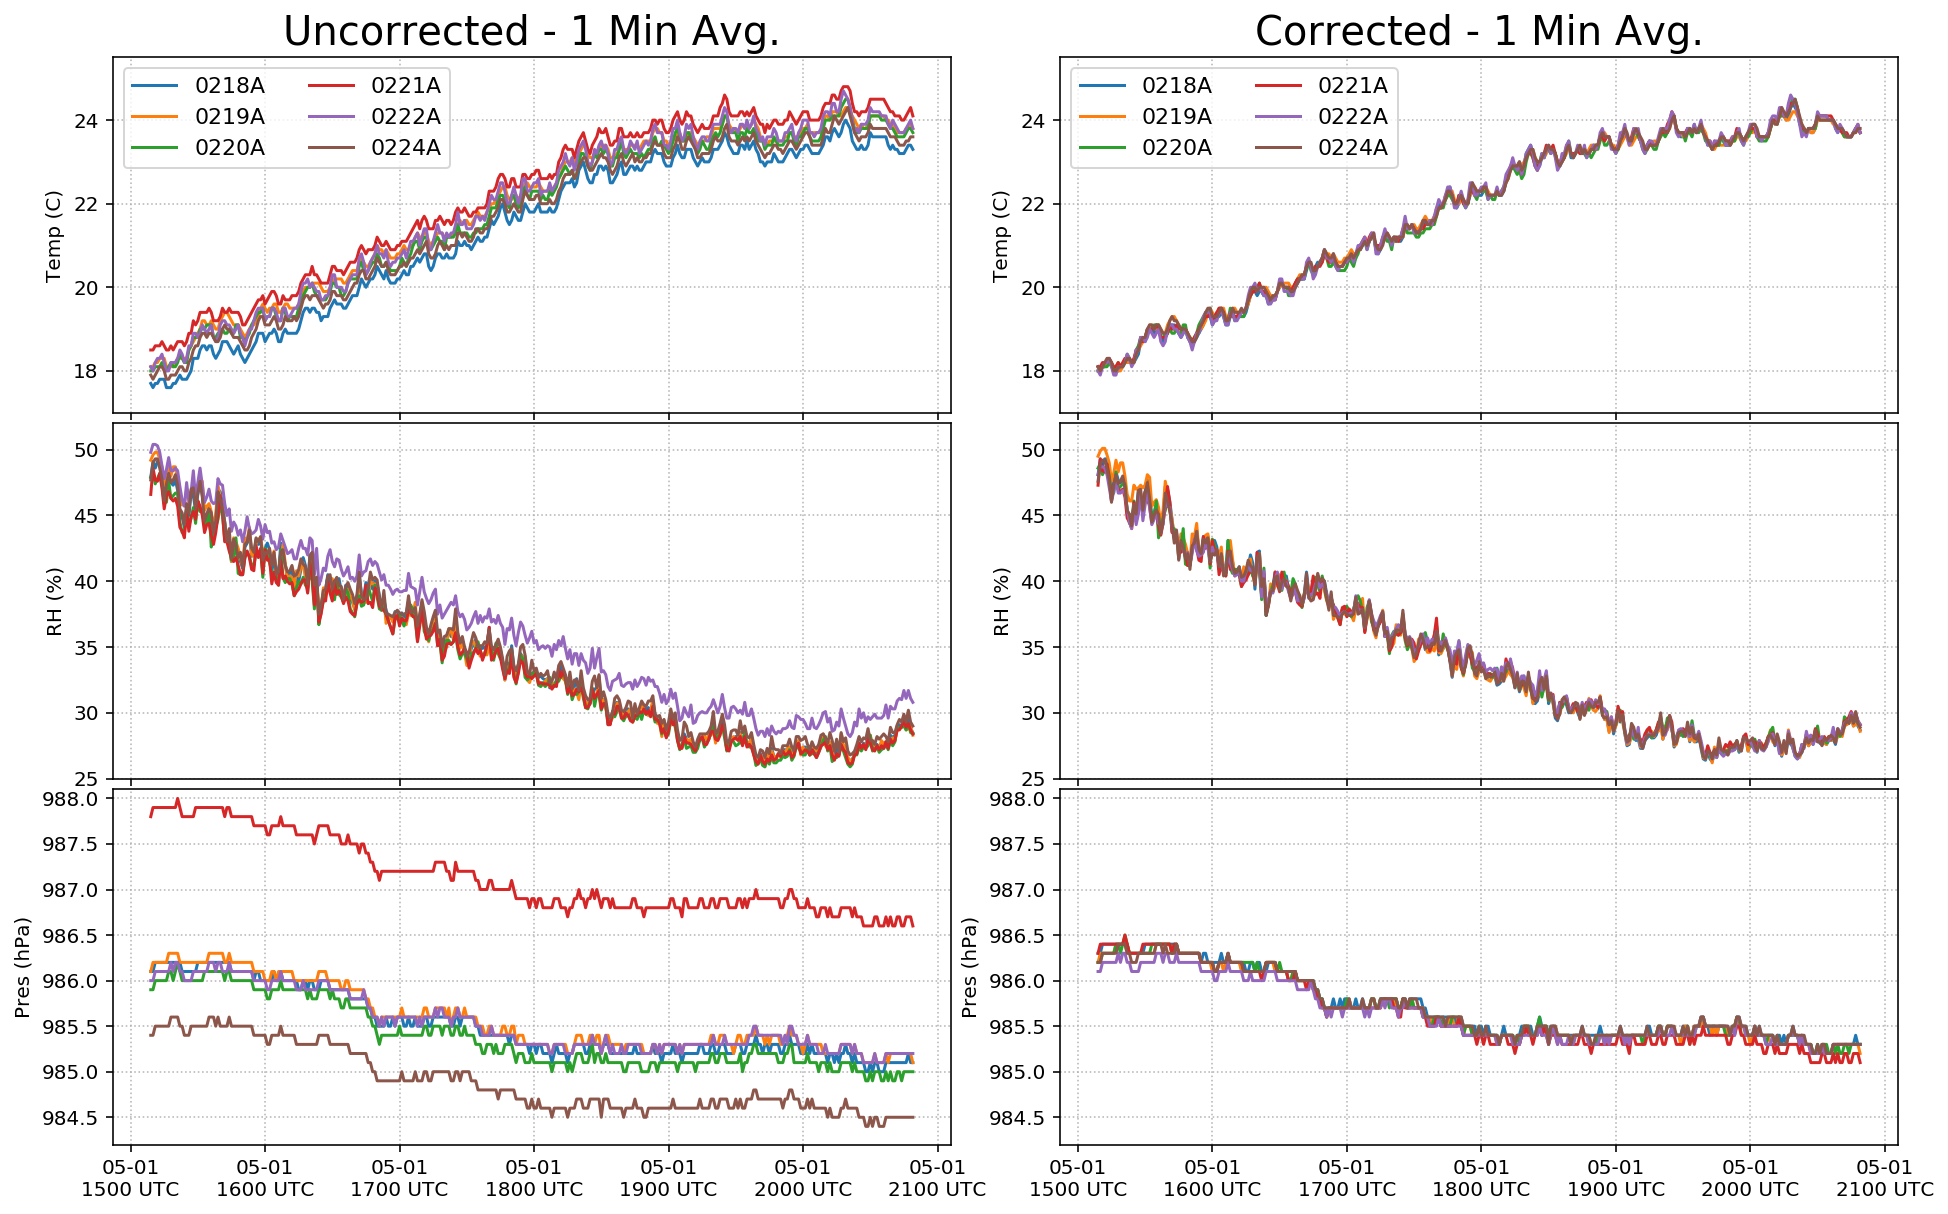

In [31]:
fig, axesall = plt.subplots(3,2, figsize=(16,10), sharex=True)

axes = axesall[:,0]


for ax in axesall.flatten():
    ax.xaxis_date()

for sn in SN:

    axes[0].plot(df_t_M.index, df_t_M[sn], label=sn)
    axes[1].plot(df_rh_M.index, df_rh_M[sn], label=sn)
    axes[2].plot(df_p_M.index, df_p_M[sn], label=sn)
    
axes[0].legend(fontsize=11, ncol=2)

axes[0].set_ylabel('Temp (C)')
axes[1].set_ylabel('RH (%)')
axes[2].set_ylabel('Pres (hPa)')

axes[0].set_ylim(17,25.5)
axes[1].set_ylim(25,52)
axes[2].set_ylim(984.2,988.1)

axes[0].set_title('Uncorrected - 1 Min Avg.', fontsize=20, y=1);

###############

axes = axesall[:,1]
#fig, axes = plt.subplots(3,1, figsize=(12,10))

for sn in SN:

    axes[0].plot(df_t_M.index, df_t_M[sn]  - biases.loc[sn]['T'], label=sn)
    axes[1].plot(df_rh_M.index, df_rh_M[sn]- biases.loc[sn]['RH'], label=sn)
    axes[2].plot(df_p_M.index, df_p_M[sn]  - biases.loc[sn]['P'], label=sn)
    
axes[0].legend(fontsize=11, ncol=2)

axes[0].set_ylabel('Temp (C)')
axes[1].set_ylabel('RH (%)')
axes[2].set_ylabel('Pres (hPa)')

axes[0].set_ylim(17,25.5)
axes[1].set_ylim(25,52)
axes[2].set_ylim(984.2,988.1)


axes[0].set_title('Corrected - 1 Min Avg.', fontsize=20, y=1);


for ax in axesall.flatten():
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d\n%H%M UTC'))
    ax.grid(linestyle=':', alpha=0.9)

plt.subplots_adjust(hspace=0.03, wspace=0.13)

In [44]:
savedir = '/Users/jessmcd/Documents/other/20170430_RapidProbeData/data_qc_corrected/'
files = glob.glob('/Users/jessmcd/Documents/other/20170430_RapidProbeData/data_qc/*.csv')

for f in files:
    print(ID)
    
    df = pd.read_csv(f, index_col=0)
    ID = '0'+str(int(df['ID'][0]))+'A'
    
    df['T']  = np.round(df['T']-biases.loc[ID]['T'],1)
    df['RH'] = np.round(df['RH']-biases.loc[ID]['RH'],1)
    df['P']  = np.round(df['P']-biases.loc[ID]['P'],1)
    
    fname=f.split('/')[-1]
    df.to_csv(savedir+fname)
    

0222A
0222A
0221A
0218A
0219A
0220A


In [46]:
df = pd.read_csv('/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/ALL_EVENTS_full_thermo_R20km.csv')

In [57]:
df = df[(df['date']==20170430) & (df['N_ID'].isna()==True)]

df1 = df[['ID','Lats', 'Lons']]

In [59]:
df1.to_csv('/Users/jessmcd/Documents/other/20170430_RapidProbeData/data_qc/Probe_Locs.txt', index=False)

In [62]:
df = pd.read_csv('/Users/jessmcd/Documents/other/20170430_RapidProbeData/data_qc/20170430_bias.txt')
df

,ID,T,RH,P
0,0218A,-0.4,-0.2,-0.2
1,0219A,0.1,-0.3,-0.1
2,0220A,-0.0,-0.7,-0.3
3,0221A,0.4,-0.7,1.5
4,0222A,0.1,1.7,-0.1
5,0224A,-0.2,0.1,-0.8
